## Compositional analysis

This script is to run scCODA on our CD4 T cells.

__author__ = "Ciro Ramírez-Suástegui"

__copyright__ = "Copyright 2022-07-01, La Jolla Institute for Immunology"

__license__ = "GPL"

__version__ = "0.0.9"

__maintainer__ = "La Jolla Institute for Immunology"

__email__ = "ciro@lji.org, cramsuig@gmail.com"

__status__ = "Prototype"

### Environment setup

In [1]:
# basic modules
import os, re, time, importlib
import sys, warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import clear_output

In [2]:
# in-house/developing modules
# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
sc.logging.print_versions()

2022-07-05 14:12:12.491604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/share/apps/gcc/6.3/lib64:/share/apps/libs/boost/boost_1_63_0/lib:/share/apps/moab/lib:/share/apps/openmpi/4.0.3/lib:/mnt/BioHome/ciro/bin/fftw-3.3.8
2022-07-05 14:12:12.491677: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
arviz                                       0.12.1
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
certifi                                     2022.06.15
cffi                                        1.15.1
cftime                                      1.6.1
charset_normalizer                          2.1.0
cloudpickle                                 2.1.0
cycler                                      0.10.0
cython_runtime                              NA
dateutil                                    2.8.2
debugpy                                     1.6.0
decorator                                   5.1.1
defusedxml  

In [3]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(10, 10))

In [4]:
# temporary lines - remove after placing file in the right folder
project_dir = "/mnt/BioAdHoc/Groups/vd-vijay/ciro/asthma_airways/results/compositional"
os.chdir(project_dir)

In [5]:
print("Working at:\n" + os.getcwd()); time.sleep(3); clear_output()
print("Environment:", re.sub('.*conda', 'conda', os.__file__));
print("Working at:", os.path.basename(os.getcwd()))

Environment: conda3/envs/sccoda_0.1.8/lib/python3.8/os.py
Working at: compositional


In [6]:
spam_spec = importlib.util.find_spec("load_ext")
if spam_spec is not None:
    %load_ext autoreload
    %autoreload 2
    %load_ext lab_black
else:
    print("No pretty code for us today")

No pretty code for us today


### Global variables and paths

In [7]:
adata_f = "/home/fcastaneda/fcastaneda/rnaseq-sc-standar/Rebuttal_CD4/results/cellrank/anndata_states_infi_fatemaps.h5ad"

### Loading data

In [8]:
adata = sc.read(adata_f)

In [9]:
adata

AnnData object with n_obs × n_vars = 27358 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'orig.0.4', 'orig.0.6', 'RD.TOTL', 'RD.PASS', 'RD.UNIQ', 'N.SNP', 'BEST', 'SNG.1ST', 'SNG.LLK1', 'SNG.2ND', 'SNG.LLK2', 'SNG.LLK0', 'DBL.1ST', 'DBL.2ND', 'ALPHA', 'LLK12', 'LLK1', 'LLK2', 'LLK10', 'LLK20', 'LLK00', 'PRB.DBL', 'PRB.SNG1', 'origlib', 'orig.class', 'orig.donor', 'cell_id', 'orig.batch', 'orig.stim', 'orig.asthma', 'orig.cell_type', 'Donor_ID', 'Init', 'orig.Sex', 'AgeEnrol', 'AgeBronc', 'BMIhist', 'BMI', 'orig.Smoking', 'AsGroup', 'AsPheno', 'GINA_Step', 'T2highInflam', 'T2highInflam10Y', 'AgeDiagnosis', 'AgeDiagnosisGroup', 'orig.OnsetLToE18Y', 'AsDurationEnrol', 'ICU_Adm', 'Hospital_Admissions_12M', 'OCS_12M', 'OCS_UseMg', 'Treatment', 'AtopySkin', 'IgE_IUpL_ML6M', 'BlEos1BpLBronc', 'BlEosCurrent1BpL3M', 'MaxBlEos1BpL10Y', 'FeNOppbEnrol', 'PreBD_FEV1L', 'PreBD_FEV1pctPred', 'PreBD_FVC_L', 'PreBD_FVCpctPred', 'PreBD_FEV1vsFVCpct', 'PreBD_FEF25to75pctPred', 'PostBD_FEV1L

### Pre-processing

In [10]:
adata.obs['Donor_condition'] = adata.obs['orig.donor'].astype(str) + '_' + adata.obs['orig.asthma'].astype(str)
cell_counts = pd.crosstab(adata.obs['Donor_condition'], adata.obs['cluster.celltype_subset'])
cell_counts['Donor_condition'] = cell_counts.index.tolist()
cell_counts.reset_index(drop=True, inplace=True)
cell_counts

cluster.celltype_subset,0: TRMDP,1: TRMSP,2: TCM,3: Treg,4: TFH,5: ThIFNr,7: CellCycle,8: CTLs,Donor_condition
0,212,862,177,57,32,54,5,2,NIHMA_206_MA
1,71,722,358,117,76,75,9,19,NIHMA_225_MA
2,129,1154,307,48,40,32,3,1,NIHMA_226_MA
3,23,33,11,11,6,8,16,2,NIHMA_228_MA
4,94,920,399,118,23,75,14,12,NIHMA_244_MA
5,507,434,339,34,112,13,42,31,NIHMA_245_MA
6,1493,355,303,102,307,43,57,69,NIHMA_246_MA
7,77,1319,278,90,27,59,26,4,NIHMA_249_MA
8,873,515,173,53,20,69,35,4,NIHMA_254_MA
9,17,54,101,106,13,11,1,14,NIHW_00011_SA


In [11]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Donor_condition"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Donor_condition"].str.replace(r".*_", "")
print(data_all)

AnnData object with n_obs × n_vars = 25 × 8
    obs: 'Donor_condition', 'Condition'


In [12]:
data_all.obs

cluster.celltype_subset,Donor_condition,Condition
0,NIHMA_206_MA,MA
1,NIHMA_225_MA,MA
2,NIHMA_226_MA,MA
3,NIHMA_228_MA,MA
4,NIHMA_244_MA,MA
5,NIHMA_245_MA,MA
6,NIHMA_246_MA,MA
7,NIHMA_249_MA,MA
8,NIHMA_254_MA,MA
9,NIHW_00011_SA,SA


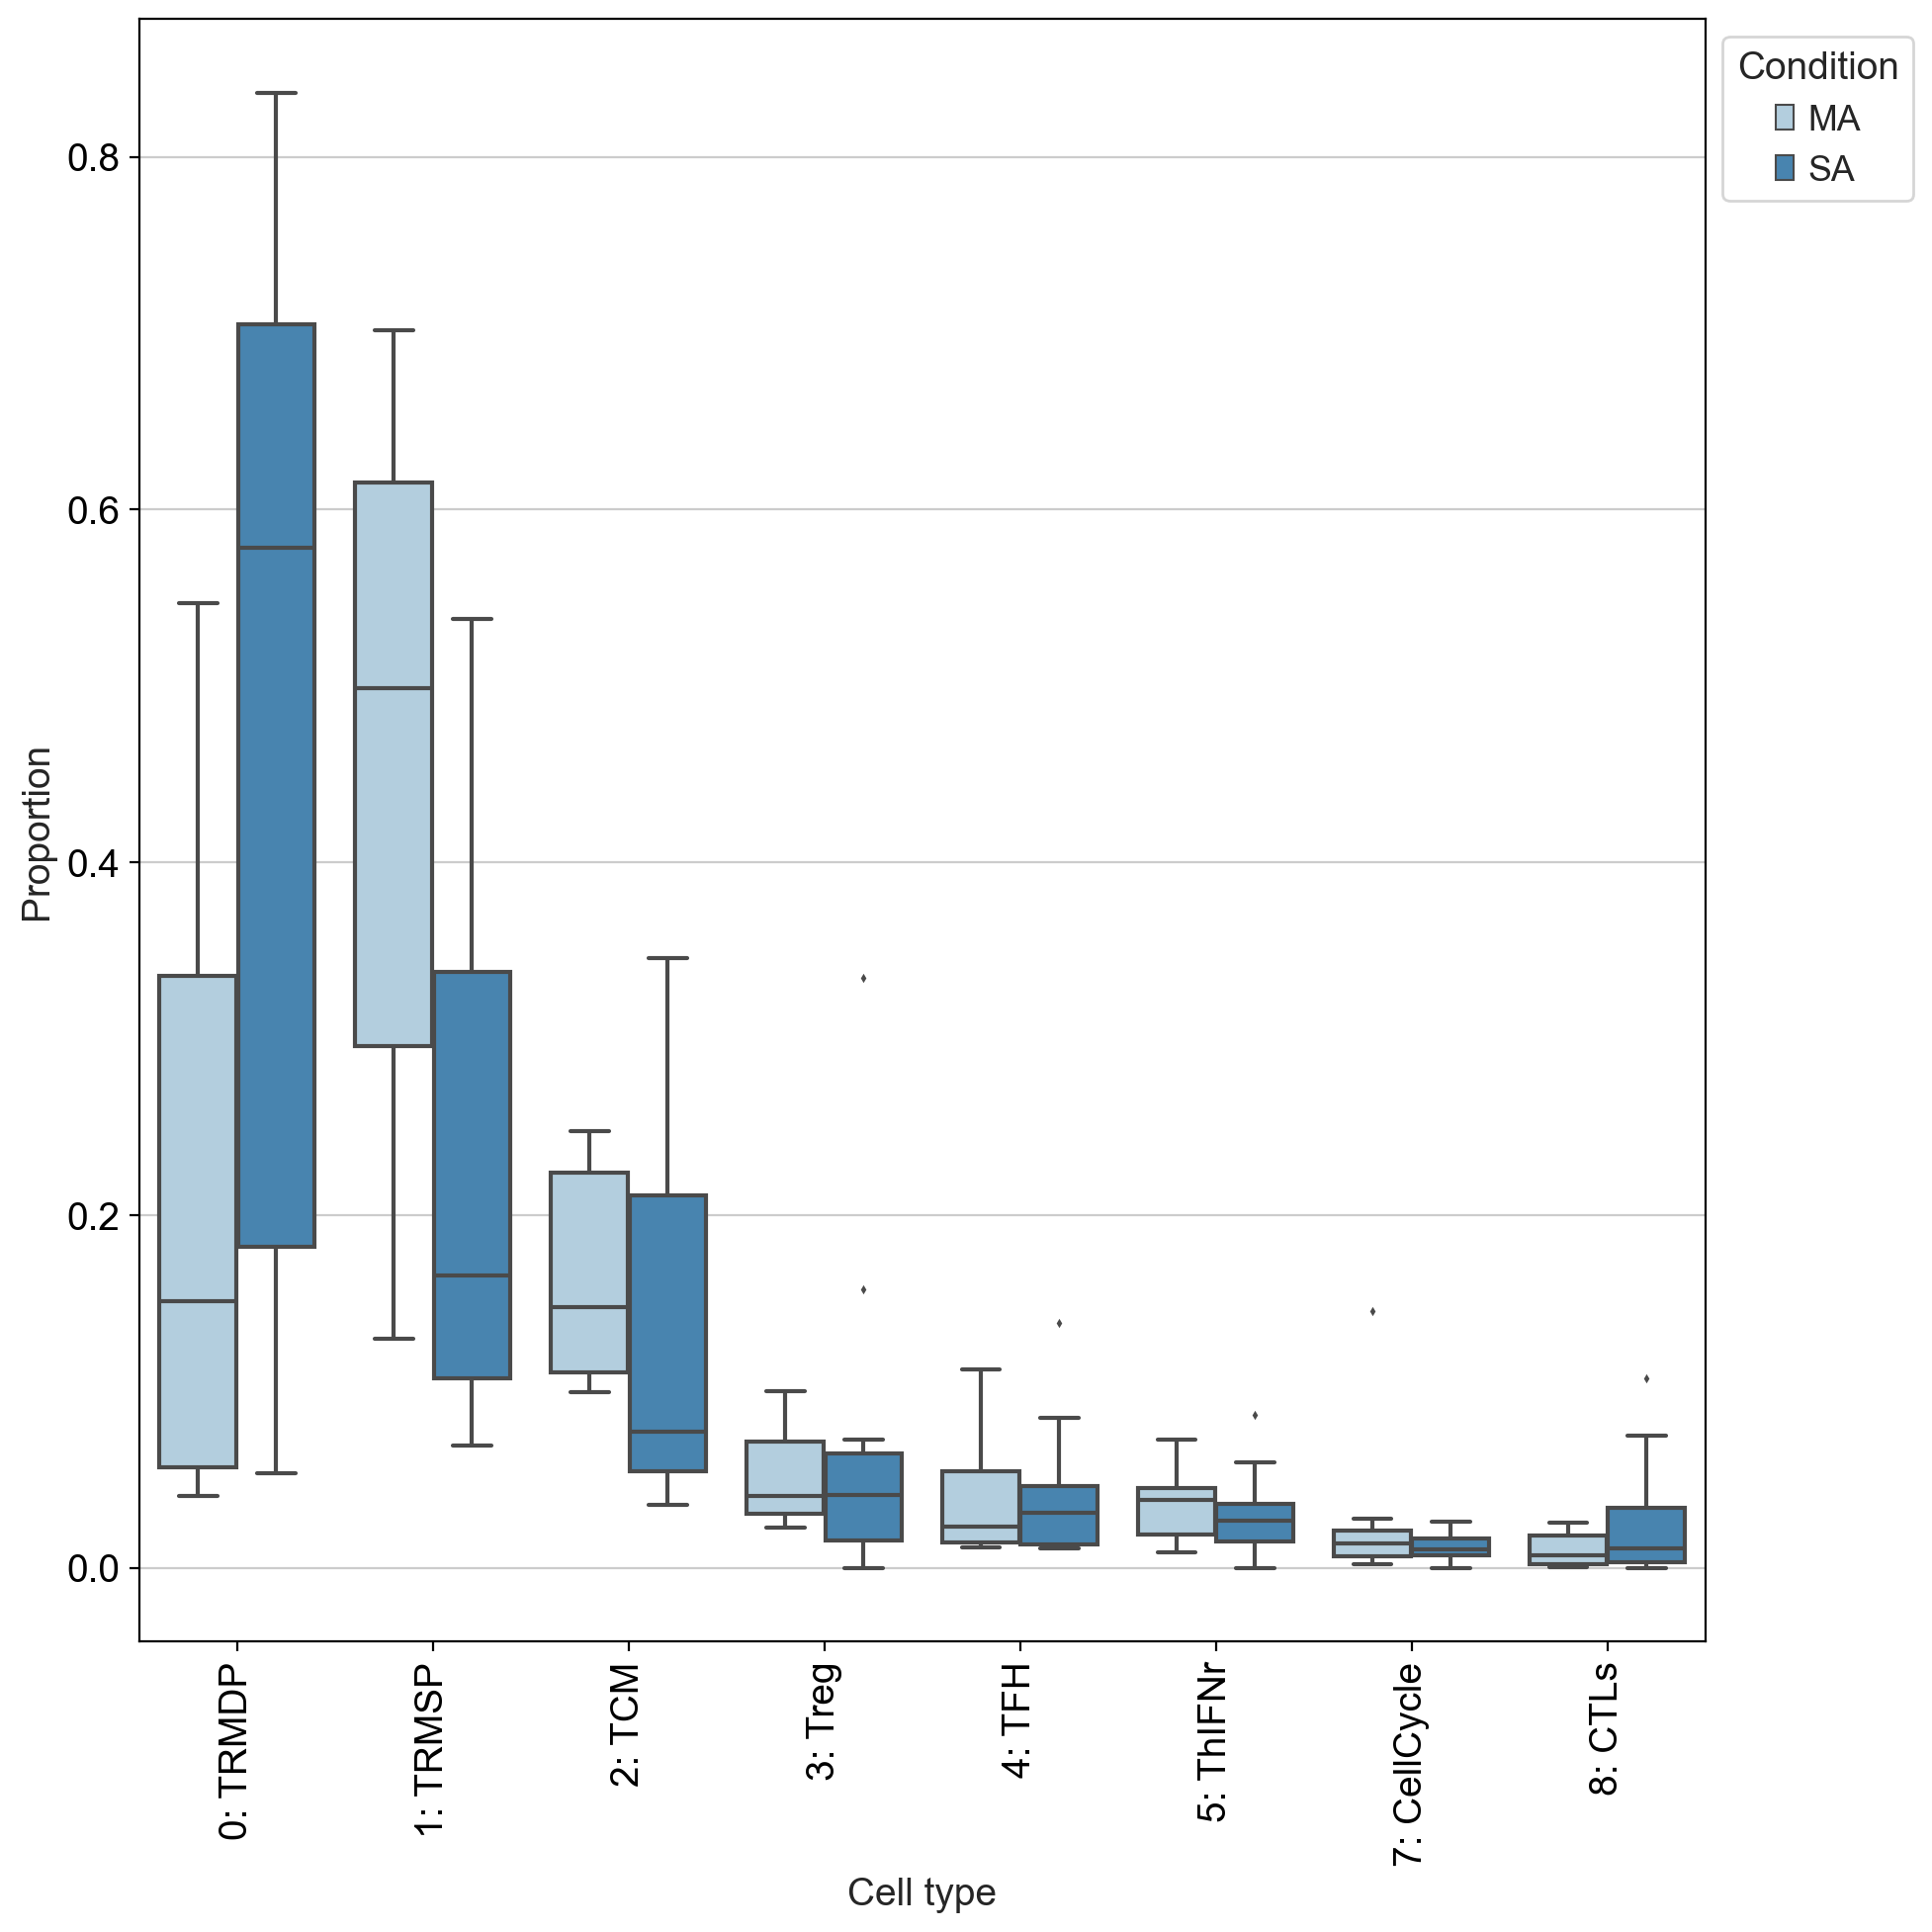

In [13]:
viz.boxplots(data_all, feature_name="Condition")
plt.savefig('sccoda_boxplot.pdf', bbox_inches='tight')
plt.show()

### Main

#### Create the model

And run inference on it.

In [14]:
model_all = mod.CompositionalAnalysis(data_all, formula="Condition", reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to 5: ThIFNr
Zero counts encountered in data! Added a pseudocount of 0.5.


2022-07-05 14:14:06.331507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/share/apps/gcc/6.3/lib64:/share/apps/libs/boost/boost_1_63_0/lib:/share/apps/moab/lib:/share/apps/openmpi/4.0.3/lib:/mnt/BioHome/ciro/bin/fftw-3.3.8
2022-07-05 14:14:06.331561: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 14:14:06.331594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (herman-login2.hpc.lji.org): /proc/driver/nvidia/version does not exist
2022-07-05 14:14:06.336594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in ot

HMC sampling is then initiated.

In [16]:
# Run MCMC
sim_results = model_all.sample_hmc()

2022-07-05 14:15:06.240424: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x2aed10014810 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-05 14:15:06.240473: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
  0%|                                                                                                                                          | 0/20000 [00:00<?, ?it/s]2022-07-05 14:15:06.327980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-07-05 14:15:07.495530: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [

MCMC sampling finished. (213.475 sec)
Acceptance rate: 60.6%


#### Interpretation

Intercepts show how the cell types are distributed without any active covariates. Effects show how the covariates influence the cell types.

In [17]:
sim_results.summary()

Compositional Analysis summary:

Data: 25 samples, 8 cell types
Reference index: 5
Formula: Condition

Intercepts:
              Final Parameter  Expected Sample
Cell Type                                     
0: TRMDP                0.899       205.052448
1: TRMSP                1.654       436.271952
2: TCM                  0.763       178.978519
3: Treg                -0.085        76.651241
4: TFH                 -0.251        64.927145
5: ThIFNr              -0.356        58.455501
7: CellCycle           -0.722        40.539053
8: CTLs                -0.912        33.524141


Effects:
                              Final Parameter  Expected Sample  \
Covariate       Cell Type                                        
Condition[T.SA] 0: TRMDP                  0.0       205.052448   
                1: TRMSP                  0.0       436.271952   
                2: TCM                    0.0       178.978519   
                3: Treg                   0.0        76.651241   
        

In [18]:
print(sim_results.credible_effects())

Covariate        Cell Type   
Condition[T.SA]  0: TRMDP        False
                 1: TRMSP        False
                 2: TCM          False
                 3: Treg         False
                 4: TFH          False
                 5: ThIFNr       False
                 7: CellCycle    False
                 8: CTLs         False
Name: Final Parameter, dtype: bool


#### Adjusting the False discovery rate

Credible and non-credible effects depends on the false discovery rate (FDR). Default is 0.05 but we can increase it to be less conservative. We'll use 0.2 and 0.4 (the common threshold in medical science is 0.4).

In [24]:
sim_results.set_fdr(est_fdr=0.4)
sim_results.summary()

Compositional Analysis summary:

Data: 25 samples, 8 cell types
Reference index: 5
Formula: Condition

Intercepts:
              Final Parameter  Expected Sample
Cell Type                                     
0: TRMDP                0.899       205.052448
1: TRMSP                1.654       436.271952
2: TCM                  0.763       178.978519
3: Treg                -0.085        76.651241
4: TFH                 -0.251        64.927145
5: ThIFNr              -0.356        58.455501
7: CellCycle           -0.722        40.539053
8: CTLs                -0.912        33.524141


Effects:
                              Final Parameter  Expected Sample  \
Covariate       Cell Type                                        
Condition[T.SA] 0: TRMDP             0.676088       432.144988   
                1: TRMSP            -0.679978       236.913479   
                2: TCM              -0.319900       139.319942   
                3: Treg             -0.118092        73.008837   
        

In [25]:
print(sim_results.credible_effects())

Covariate        Cell Type   
Condition[T.SA]  0: TRMDP         True
                 1: TRMSP         True
                 2: TCM           True
                 3: Treg          True
                 4: TFH           True
                 5: ThIFNr       False
                 7: CellCycle    False
                 8: CTLs          True
Name: Final Parameter, dtype: bool


Now let's check 0.2

In [26]:
sim_results.set_fdr(est_fdr=0.2)
sim_results.summary()

Compositional Analysis summary:

Data: 25 samples, 8 cell types
Reference index: 5
Formula: Condition

Intercepts:
              Final Parameter  Expected Sample
Cell Type                                     
0: TRMDP                0.899       205.052448
1: TRMSP                1.654       436.271952
2: TCM                  0.763       178.978519
3: Treg                -0.085        76.651241
4: TFH                 -0.251        64.927145
5: ThIFNr              -0.356        58.455501
7: CellCycle           -0.722        40.539053
8: CTLs                -0.912        33.524141


Effects:
                              Final Parameter  Expected Sample  \
Covariate       Cell Type                                        
Condition[T.SA] 0: TRMDP             0.676088       429.096341   
                1: TRMSP            -0.679978       235.242129   
                2: TCM              -0.319900       138.337084   
                3: Treg              0.000000        81.580733   
        

In [27]:
print(sim_results.credible_effects())

Covariate        Cell Type   
Condition[T.SA]  0: TRMDP         True
                 1: TRMSP         True
                 2: TCM           True
                 3: Treg         False
                 4: TFH          False
                 5: ThIFNr       False
                 7: CellCycle    False
                 8: CTLs         False
Name: Final Parameter, dtype: bool


### Conclusions

So we have that with a 0.2 False Discovery Rate we see the two TRM clusters and TCM are differentially abundant.

### Save

In [29]:
# saving
path = "./model_result"
sim_results.save(path)

In [30]:
# loading
with open(path, "rb") as f:
    sim_results_2 = pkl.load(f)

sim_results_2.summary()

Compositional Analysis summary:

Data: 25 samples, 8 cell types
Reference index: 5
Formula: Condition

Intercepts:
              Final Parameter  Expected Sample
Cell Type                                     
0: TRMDP                0.899       205.052448
1: TRMSP                1.654       436.271952
2: TCM                  0.763       178.978519
3: Treg                -0.085        76.651241
4: TFH                 -0.251        64.927145
5: ThIFNr              -0.356        58.455501
7: CellCycle           -0.722        40.539053
8: CTLs                -0.912        33.524141


Effects:
                              Final Parameter  Expected Sample  \
Covariate       Cell Type                                        
Condition[T.SA] 0: TRMDP             0.676088       429.096341   
                1: TRMSP            -0.679978       235.242129   
                2: TCM              -0.319900       138.337084   
                3: Treg              0.000000        81.580733   
        

And we check that it was saved correctly.